# Day 1 : Collecting images

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [7]:
# Dataset
# http://vis-www.cs.umass.edu/lfw/

In [8]:
#!tar -xf lfw.tgz

In [9]:
#for directory in os.listdir('lfw'):
 #   for file in os.listdir(os.path.join('lfw', directory)):
  #      EX_PATH = os.path.join('lfw', directory, file)
   #     NEW_PATH = os.path.join(NEG_PATH, file)
    #    os.replace(EX_PATH, NEW_PATH)

In [10]:
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\f7ac97de-3e8e-11ed-95ef-a86daadb0fd2.jpg'

In [12]:
plt.imshow(frame[120:120+250,200:200+250, :])

NameError: name 'frame' is not defined

# Day 2: Data Augmentation

In [13]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [14]:
import os
import uuid

In [17]:
img_path = os.path.join(ANC_PATH, 'fdbf4e68-38ca-11ed-bf47-a86daadb0fd2.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [19]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [20]:
dir_test = anchor.as_numpy_iterator()

In [21]:
print(dir_test.next())

b'data\\anchor\\f691683a-38ca-11ed-8ea8-a86daadb0fd2.jpg'


In [22]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [26]:
img = preprocess('data\\anchor\\f691683a-38ca-11ed-8ea8-a86daadb0fd2.jpg')

In [27]:
img.numpy().max() 

1.0

In [29]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [30]:
samples = data.as_numpy_iterator()

In [31]:
exampple = samples.next()

In [32]:
exampple

(b'data\\anchor\\c3cbbe66-38ca-11ed-8d8a-a86daadb0fd2.jpg',
 b'data\\positive\\1644d927-3e8f-11ed-9e15-a86daadb0fd2.jpg',
 1.0)

In [33]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [34]:
res = preprocess_twin(*exampple)

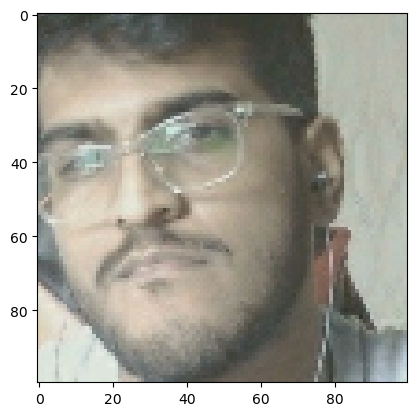

In [35]:
plt.imshow(res[1])

In [36]:
res[2]

1.0

In [37]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [38]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [39]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [40]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [41]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [42]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
embedding = make_embedding()

In [44]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [45]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [46]:
l1 = L1Dist()

In [47]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [48]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [49]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

In [50]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [51]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [52]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [53]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [54]:
siamese_model = make_siamese_model()

In [55]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [56]:

binary_cross_loss = tf.losses.BinaryCrossentropy()

In [57]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [58]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [59]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]

In [60]:
y

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [61]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [62]:
from tensorflow.keras.metrics import Precision, Recall

In [63]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [64]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


# Day 3 : Training and Evaluation